# About descriptives_sequence_analysis

This notebook runs descriptives and clustering analysis on sequence actions.

In [1]:
%load_ext autoreload
%autoreload 1
%aimport utils_read_parsing
%aimport utils_timeline_viz
%aimport utils_sequence_parsing
from utils_read_parsing import *
from utils_timeline_viz import *
from utils_sequence_parsing import converter, Sequence
import os
import numpy as np
import pandas as pd
import getpass
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
pd.set_option('display.max_columns', None);pd.set_option('display.max_rows', None);pd.set_option('precision', 2)
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 12,4

# Loading student and sequence data

In [2]:
log_files_per_sim = {}
for sim in ['beers','capacitor']:
    log_files_per_sim[sim] = get_parsed_log_files_per_student_for_sim(sim)

The file Sarah_beers_log_files_per_student.txt has been unpickled and loaded
The file Sarah_capacitor_log_files_per_student.txt has been unpickled and loaded


In [3]:
df_all = get_df_all_factors()

In [4]:
ids = list(set(df_all['sid']))
N = len(ids)
print N

147


In [5]:
import pickle
pickle_in_seqs = open(os.path.join(BIG_FOLDER,'all_massaged_data\\dict_by_sim_by_student_parsed_seqs.txt'),"r")
all_seqs = pickle.load(pickle_in_seqs)
pickle_in_seqs.close()

# Descriptives of blocked seqs

## Tranform sequences

In [6]:
%%time
transformed_seqs = {}
for sim,seqs_by_student in all_seqs.iteritems():
    transformed_seqs[sim] = {}
    for sid,seq in seqs_by_student.iteritems():
        seq.remove_actions('ignore')
        seq.merge_actions(['P','P_notes'])
        seq.block_actions(['P','V_area', 'V_battery', 'V_lightbulb', 'V_separation','V_other','V_width','V_concentration','V_wavelength','V_detector','V_laser','V_ruler'])
        seq.check_lengths_seq_timecoords()
        transformed_seqs[sim][sid] = seq

Wall time: 344 ms


## Test on 1 student

C:\Users\Sarah\Anaconda2\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


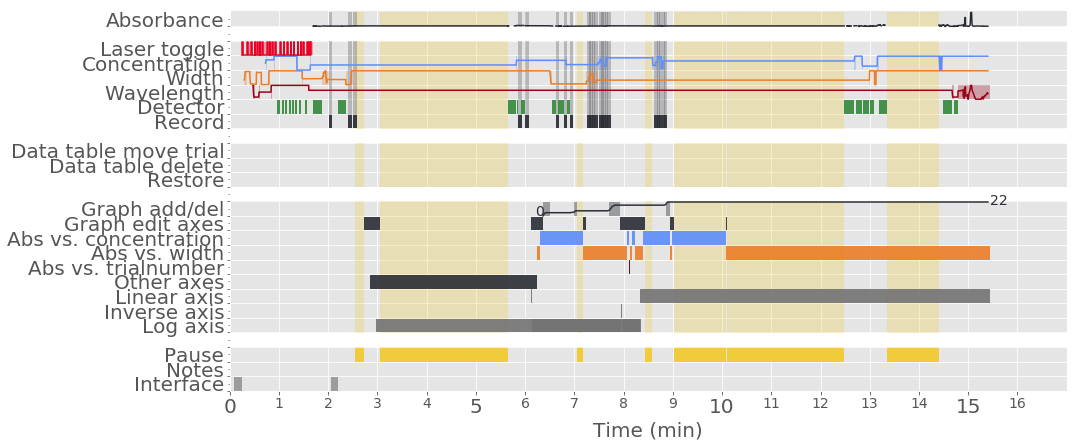

In [7]:
sim = 'beers'
to_plot = to_plot_beers
test_sid = 19989152
df = prep_parsing_data(log_files_per_sim[sim][test_sid][0]) 
plt.figure(figsize=(15,7))
plot(df,to_plot,family_name_to_code,function_to_use,colors)

In [8]:
transformed_seqs[sim][test_sid]

Sequence(V_laser,V_other,V_laser,V_other,V_laser,V_other,V_laser,V_other,V_laser,V_other,V_laser,V_other,V_laser,V_other,V_laser,V_other,V_laser,V_other,V_laser,V_other,V_laser,V_other,V_laser,V_other,V_laser,V_other,V_laser,V_other,V_laser,V_other,V_laser,V_other,V_laser,V_other,V_laser,V_other,V_laser,V_other,V_laser,V_other,V_laser,V_other,V_laser,V_detector,V_width,T_add,V_detector,V_width,T_add,V_width,T_add,P,G_axis_concentration,G_axis_trialnumber,G_axis_width,G_axis_trialnumber,G_scale_inverse,G_scale_log,G_scale_inverse,G_scale_log,P,V_detector,V_concentration,V_detector,T_add,V_detector,T_add,G_scale_inverse,G_scale_linear,G_scale_log,G_axis_outcome,G_axis_concentration,G_add,G_add,G_add,G_add,G_add,V_width,V_detector,T_add,V_detector,T_add,V_concentration,V_detector,T_add,G_add,G_add,G_add,P,G_axis_trialnumber,V_width,T_add,V_width,T_add,V_width,T_add,V_width,T_add,V_width,V_concentration,T_add,V_concentration,T_add,V_concentration,T_add,V_concentration,T_add,V_concentration

## Individual actions

We care about:
1. how many sequences the action is found in,
2. how many times it's used byt students.
-> histogram start at counts of 1 not zero.

In [9]:
nb_use = {}
for sim in ['beers','capacitor']:
    for student, seq in transformed_seqs[sim].iteritems():
        for a in seq.actions:
            if a not in nb_use.keys():
                nb_use[a] = []
            nb_use[a].append(seq.seq.count(a))
actions = nb_use.keys()
actions.sort()

In [10]:
# fig,axes = plt.subplots(nrows=len(actions),ncols=1,figsize=(10,4*len(actions)))
# for i,a in enumerate(actions):
#     ax=axes[i]
#     (n, bins, patches) = ax.hist(nb_use[a],bins=range(max(nb_use[a])))
#     ax.set(title='Distribution of action "{0}" used in {1} sequences'.format(a,len(nb_use[a])))
#     ax.set(ylabel='Number of sequences')

In [11]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('seq_actions_hist_both_sims.pdf') as pdf:
    for i,a in enumerate(actions):
        plt.hist(nb_use[a],bins=range(max(nb_use[a])))
        plt.title('Hist of number of episodes for "{0}" found in {1} sequences'.format(a,len(nb_use[a])))
        plt.ylabel('Number of sequences')
        plt.tight_layout()
        pdf.savefig()
        plt.close()

## Lengths

In [12]:
nb_actions = []
lengths = []
for sim in ['beers','capacitor']:
    for student, seq in transformed_seqs[sim].iteritems():
        nb_actions.append(len(seq.seq))
        lengths.append(seq.timecoords[-1])

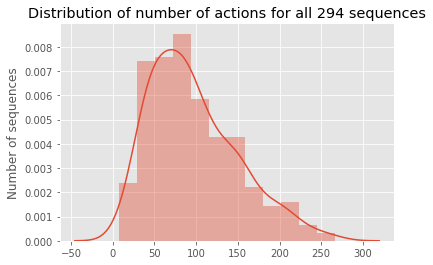

In [13]:
sns.distplot(nb_actions)
plt.title('Distribution of number of actions for all {0} sequences'.format(N*2))
plt.ylabel('Number of sequences');

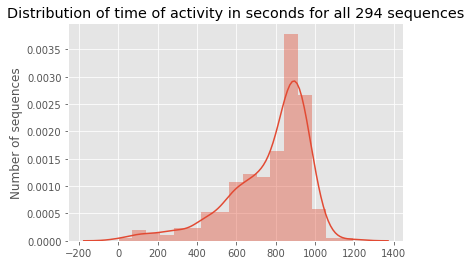

In [14]:
sns.distplot(lengths)
plt.title('Distribution of time of activity in seconds for all {0} sequences'.format(N*2))
plt.ylabel('Number of sequences');

## When do they pause?

Need ot normalize by 1) frequency of action and 2) number of pauses per student

* for each sequence find # of times action A before P
* divide by number of P
* get a percentage
* then normalize by overall frequency of action in all sequences???

In [15]:
freq_beforeP = {key:[] for key in actions}
freq_afterP = {key:[] for key in actions}
all_actions = []
for a in actions:
    for sim in ['beers','capacitor']:
        for student, sequence in transformed_seqs[sim].iteritems():
            count_beforeP = sum([1 for i, s in enumerate(sequence.seq) if s == 'P' and sequence.seq[i-1]==a])
            afterP = [sequence.seq[i+1] for i, s in enumerate(sequence.seq) if s == 'P' and i!=len(sequence.seq)-1]
            count_afterP = sum([1 for s in afterP if s==a])
            number_P = float(sequence.seq.count('P'))
            freq_beforeP[a].append(count_beforeP/number_P)
            freq_afterP[a].append(count_afterP/number_P)
            all_actions.extend(sequence.seq)

counts_all_actions = {a:all_actions.count(a) for a in set(all_actions)}
score_beforeP = [(a,np.mean(freq_beforeP[a])/float(counts_all_actions[a])) for a in actions]
score_afterP = [(a,np.mean(freq_afterP[a])/float(counts_all_actions[a])) for a in actions]
score_beforeP.sort(key = lambda t: t[1],reverse=True)
score_afterP.sort(key = lambda t: t[1],reverse=True)

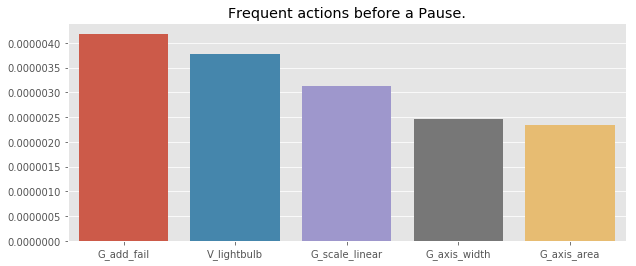

In [16]:
plt.figure(figsize=(10,4))
sns.barplot(x=list(zip(*score_beforeP[:5])[0]),y=list(zip(*score_beforeP[:5])[1]))
plt.title('Frequent actions before a Pause.');

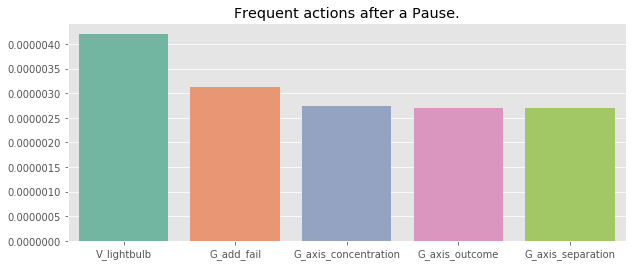

In [17]:
plt.figure(figsize=(10,4))
sns.barplot(x=list(zip(*score_afterP[:5])[0]),y=list(zip(*score_afterP[:5])[1]),palette="Set2")
plt.title('Frequent actions after a Pause.');

Observations:
* Clearly playing with the lightbulb elicits both planning and reflection.
* Students often pause before and after a Graph action: either because they need to figure out how to make a graph (Graph_add_fail) or they just changed the axes
* Student often pause after making an axis linear, or in other words after manipulating axis scales in general. Probably because they are interpreting their graph.